Updated focus of Notebook: Filter images which have no data, correct color of images

As of now it looks like the loss and Jaccard index are not well correlated. This is a problem because the loss should be a measure of how good the model is. If the loss is not correlated with the Jaccard index, then the loss is not a good measure of how good the model is. This notebook is to fix this problem.

Update 2: Dice and IoU calculate different returns when the the size of the prediction is way smaller than the ground truth. This is a problem because the loss should be a measure of how good the model is. If the loss is not correlated with the Jaccard index, then the loss is not a good measure of how good the model is.
see: https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html

Additionally both metrics work with void/empty ground truth masks. Which are used to reduce the high false positive rate of the model.

In another Notebook this problem will be tackled.

In [8]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, sampler
from torch import nn
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryJaccardIndex
from torch.utils.tensorboard import SummaryWriter

from rasterio.plot import show
from pathlib import Path
import rasterio

In [9]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        # mask and img_file have so far the same name
        mask_path = os.path.join(self.mask_dir, self.img_files[idx])
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        if self.transform:
            img = self.transform(img)
        
        return img, mask

In [3]:
img_dir = r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_only_AOI_all_seasons'
mask_dir = r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_only_AOI_all_seasons'
geo_image_dataset = GeoImageDataset(img_dir, mask_dir)

In [4]:
def gammacorr(band):
    gamma=2.2
    return np.power(band, 1/gamma)

In [10]:
def show_rgb_sample(sample):
    img, mask = sample
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    plt.imshow(torch.Tensor.numpy(mask), cmap='jet', alpha=0.5*(torch.Tensor.numpy(mask)==True))

In [5]:
def show_rgb_sample_gamma_corr(sample):
    img, mask = sample
    img = img*0.0008
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    plt.imshow(torch.Tensor.numpy(mask), cmap='jet', alpha=0.5*(torch.Tensor.numpy(mask)==True))

In [6]:
def show_nir_sample(sample):
    img, mask = sample
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[0:3,:,:]).transpose((1,2,0)))
    plt.imshow(torch.Tensor.numpy(mask), cmap='YlOrBr', alpha=0.4*(torch.Tensor.numpy(mask)==True))

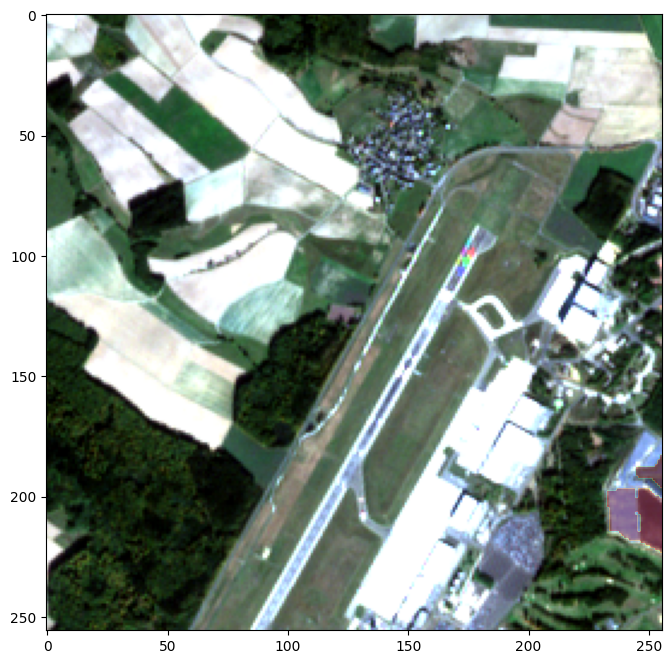

In [6]:
show_rgb_sample(geo_image_dataset[144])

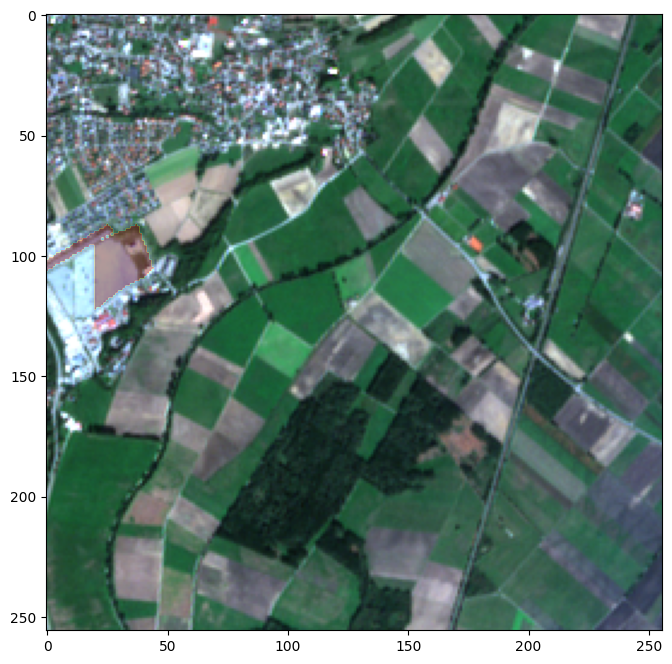

In [7]:
show_rgb_sample(geo_image_dataset[3000])

By random checking for a good image, I found a black only image which means no the image data is zero this can harm the model performance.

It looks like some of the images are empty. This shouldn't be the case.

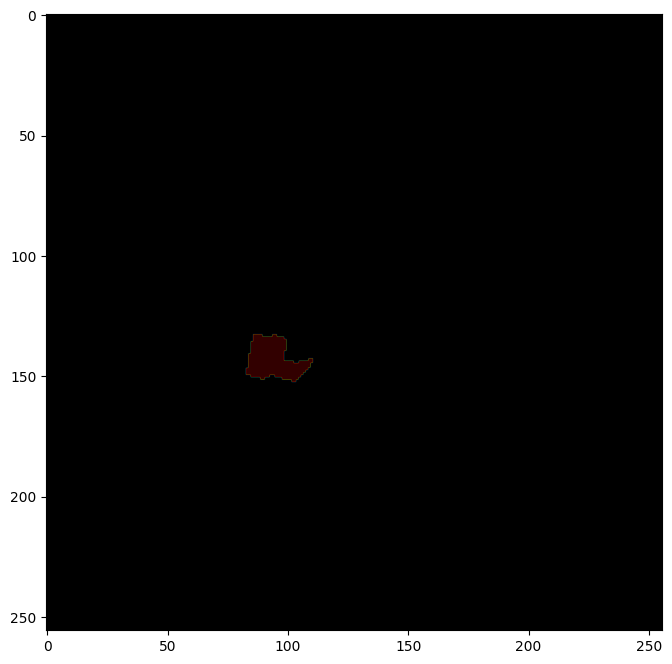

In [18]:
show_rgb_sample(geo_image_dataset[2501])

In [19]:
image, mask = geo_image_dataset[2501]

In [32]:
count = 0
for image in os.listdir(img_dir):
    img = torch.load(os.path.join(img_dir, image))
    if img.max() == 0:
        count += 1
print(f"found {count} empty images")

found 812 empty images


In [33]:
count = 0
for image in os.listdir(img_dir):
    img = torch.load(os.path.join(img_dir, image))
    if img.max() == 0:
        count += 1
        print(image)
print(f"found {count} empty images")

31UGR_10_2018-4-20.pt
31UGR_10_2018-9-27.pt
31UGR_14_2018-4-20.pt
31UGR_14_2018-9-27.pt
31UGR_15_2018-4-20.pt
31UGR_15_2018-9-27.pt
31UGR_16_2018-4-20.pt
31UGR_16_2018-9-27.pt
31UGR_18_2018-4-20.pt
31UGR_18_2018-9-27.pt
31UGR_19_2018-4-20.pt
31UGR_19_2018-9-27.pt
31UGR_20_2018-4-20.pt
31UGR_20_2018-9-27.pt
31UGR_24_2018-4-20.pt
31UGR_24_2018-9-27.pt
31UGR_25_2018-4-20.pt
31UGR_25_2018-9-27.pt
31UGR_26_2018-4-20.pt
31UGR_26_2018-9-27.pt
31UGR_2_2018-4-20.pt
31UGR_2_2018-9-27.pt
31UGR_32_2018-4-20.pt
31UGR_32_2018-9-27.pt
31UGR_44_2018-4-20.pt
31UGR_44_2018-9-27.pt
31UGR_5_2018-4-20.pt
31UGR_5_2018-9-27.pt
31UGU_1_2018-11-17.pt
31UGU_1_2018-4-21.pt
31UGU_2_2018-11-17.pt
31UGU_2_2018-4-21.pt
31UGU_3_2018-11-17.pt
31UGU_3_2018-4-21.pt
31UGU_4_2018-11-17.pt
31UGU_4_2018-4-21.pt
31UGU_5_2018-11-17.pt
31UGU_5_2018-4-21.pt
31UGU_6_2018-11-17.pt
31UGU_6_2018-4-21.pt
31UGU_7_2018-11-17.pt
31UGU_7_2018-4-21.pt
31UGU_8_2018-11-17.pt
31UGU_8_2018-4-21.pt
32TMT_4_2018-4-7.pt
32TMT_8_2018-4-7.pt
32TP

Revisit the preprocessing step to see if there is a problem.

In [11]:
image_dir = r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\training_data_raw\S2B_MSIL2A_20180927T103019_N0208_R108_T31UGR_20180927T155848"

In [12]:
import re
import os
import rasterio

# create dict to store filenames with bands as keys
band_file_map = {
    "B02": None, # blue
    "B03": None, # green
    "B04": None, # red
    "B08": None, # NIR
}

filename_regex = r"""^T(?P<tile>\d{2}[A-Z]{3})_(?P<date>\d{8}T\d{6})_(?P<band>B0\d{1})(?:_(?P<resolution>\d{2}m))?\..*$"""

# fill dict with paths and extract tile
for filename in os.listdir(image_dir):
    match = re.search(filename_regex, filename)
    if match:
        tile = match.group("tile")

    for band_name in band_file_map.keys():
        if filename.endswith(f"{band_name}_10m.jp2"):
            band_file_map[band_name] = os.path.join(image_dir, filename)
            break

# Verify that all required bands have been found
missing_bands = [band_name for band_name, file_path in band_file_map.items() if file_path is None]
if missing_bands:
    raise Exception(f"Missing band files: {missing_bands}")

# store open DatasetReaders in dict 
bands = {band_name: rasterio.open(file_path) for band_name, file_path in band_file_map.items()}

In [13]:
# get meta information's
img_crs = bands["B02"].crs
img_transform = bands["B02"].transform 

In [14]:
# read the bands form the DatasetReaders as numpy array, 1 is needed to get the right dimension (else unsqueeze) 
blue = bands["B02"].read(1)
green =  bands["B03"].read(1)
red = bands["B04"].read(1)
nir = bands["B08"].read(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


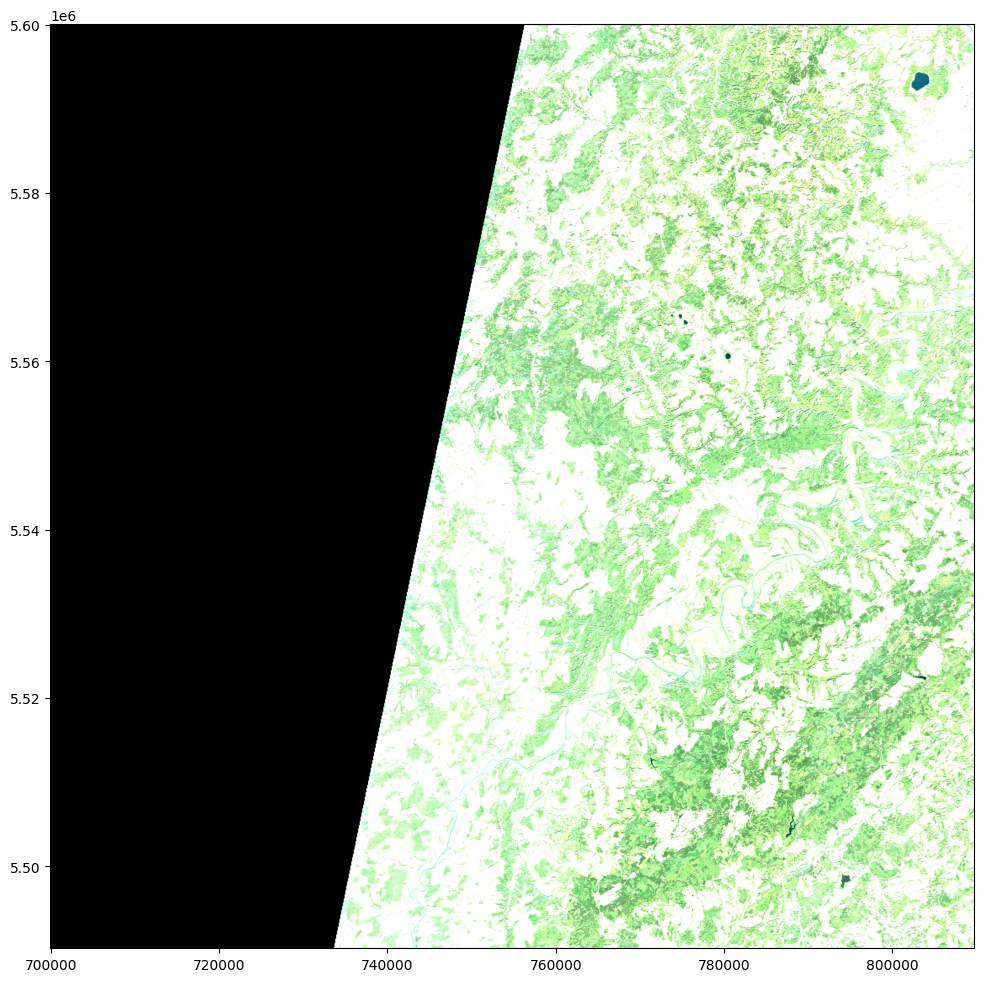

In [42]:
# plot RGB image
rgb_composite_corr = np.dstack((red, green, blue))
fig, ax = plt.subplots(1, figsize=(12, 12))
show(rgb_composite_corr.transpose((2,0,1)), transform=bands["B02"].transform, ax=ax);

https://gis.stackexchange.com/questions/380038/reasons-for-partial-tiles-in-sentinel

=> Filter images with no data

In [30]:
img_dir = r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_only_AOI_test_color_corr_2'
mask_dir = r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_only_AOI_test_color_corr_2'
geo_image_dataset = GeoImageDataset(img_dir, mask_dir)

Store image index with problem:
1. 2053 image and mask dont match

In [21]:
image, mask = geo_image_dataset[0]

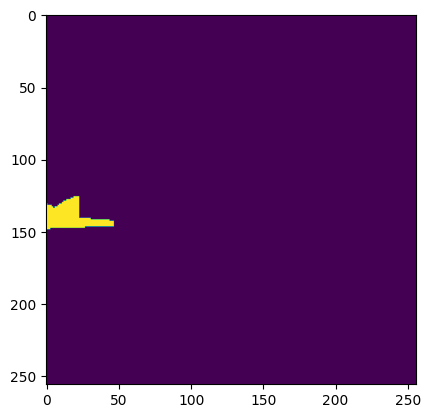

<Axes: >

In [19]:
show(torch.Tensor.numpy(mask))

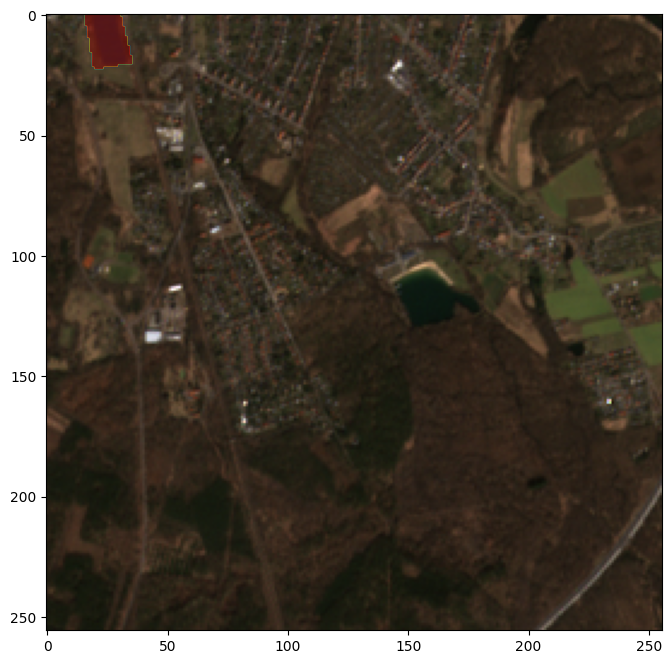

In [36]:
show_rgb_sample(geo_image_dataset[5])

In [37]:
image, mask = geo_image_dataset[5]
image.mean()

tensor(0.2634)

In [16]:
show_rgb_sample(geo_image_dataset[121])

IndexError: list index out of range

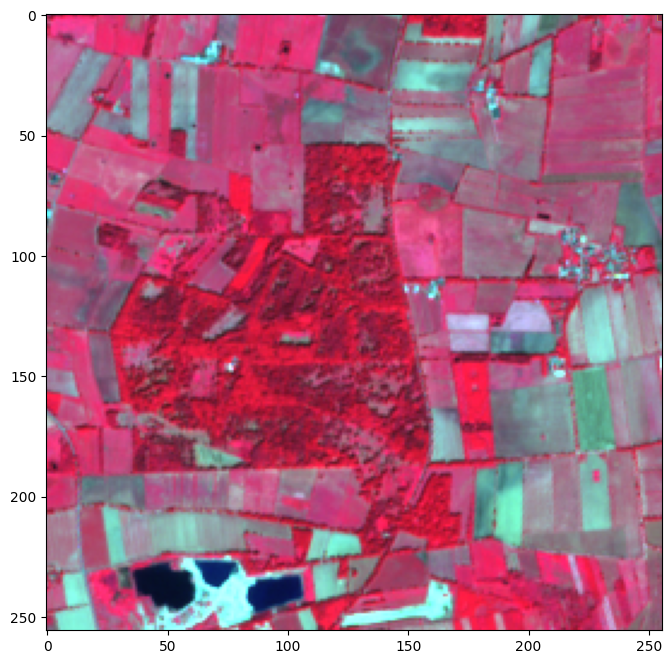

In [44]:
show_nir_sample(geo_image_dataset[2503])

### Create optimized TCI images

https://github.com/sentinel-hub/custom-scripts/blob/master/sentinel-2/l2a_optimized/script.js

In [124]:
import math
import numpy as np
import torch
from pathlib import Path
import rasterio

In [43]:
maxR = 3.0 # max reflectance
midR = 0.13
sat = 1.2
gamma = 1.8

In [85]:
def evaluatePixel(smp):
    rgbLin = satEnh(sAdj(smp["B04"]), sAdj(smp["B03"]), sAdj(smp["B02"]))
    return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2])]

In [86]:
def sAdj(a):
    return adjGamma(adj(a, midR, 1, maxR))

In [87]:
gOff = 0.01
gOffPow = math.pow(gOff, gamma)
gOffRange = math.pow(1 + gOff, gamma) - gOffPow

In [88]:
def adjGamma(b):
    return (np.power((b + gOff), gamma) - gOffPow) / gOffRange

In [89]:
# Saturation enhancement
def satEnh(r, g, b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    return [np.clip(avgS + r * sat, 0, 1), np.clip(avgS + g * sat, 0, 1), np.clip(avgS + b * sat, 0, 1)]

In [90]:
#contrast enhancement with highlight compression
def adj(a, tx, ty, maxC):
    ar = np.clip(a / maxC, 0, 1)
    return ar * (ar * (tx / maxC + ty - 1) - ty) / (ar * (2 * tx / maxC - 1) - tx / maxC)

In [91]:
def sRGB_og(c):
    return 12.92 * c if c <= 0.0031308 else 1.055 * math.pow(c, 0.41666666666) - 0.055

In [92]:
def sRGB(c):
    return np.clip(12.92 * c, 0.0031308, 1.055 * np.power(c, 0.41666666666) - 0.055)

In [93]:
image, mask = geo_image_dataset[2503]

In [7]:
image_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\training_data_raw\S2A_MSIL2A_20180330T101021_N0207_R022_T32UQC_20180330T110651")

NameError: name 'Path' is not defined

In [169]:
red = rasterio.open(image_path / "B04_10m.jp2").read(1)
green = rasterio.open(image_path / "B03_10m.jp2").read(1)
blue = rasterio.open(image_path / "B02_10m.jp2").read(1)
nir = rasterio.open(image_path / "B08_10m.jp2").read(1)

In [1]:
img = np.dstack((red, green, blue))[10500:10980, 10500:10980, :]

NameError: name 'np' is not defined

In [176]:
def robust_normalize(band, lower_bound=1, upper_bound=99):
    # get lower bound percentile
    percentile_lower_bound = np.percentile(band, lower_bound)
    # set all lower bound outliers to percentile_lower_bound value
    band[band < percentile_lower_bound] = percentile_lower_bound
    # get upper bound percentile
    percentile_upper_bound = np.percentile(band, upper_bound)
    # set all upper bound outliers to percentile_upper_bound value
    band[band > percentile_upper_bound] = percentile_upper_bound
    # normalize
    return (band - percentile_lower_bound) / (
        percentile_upper_bound - percentile_lower_bound
    )

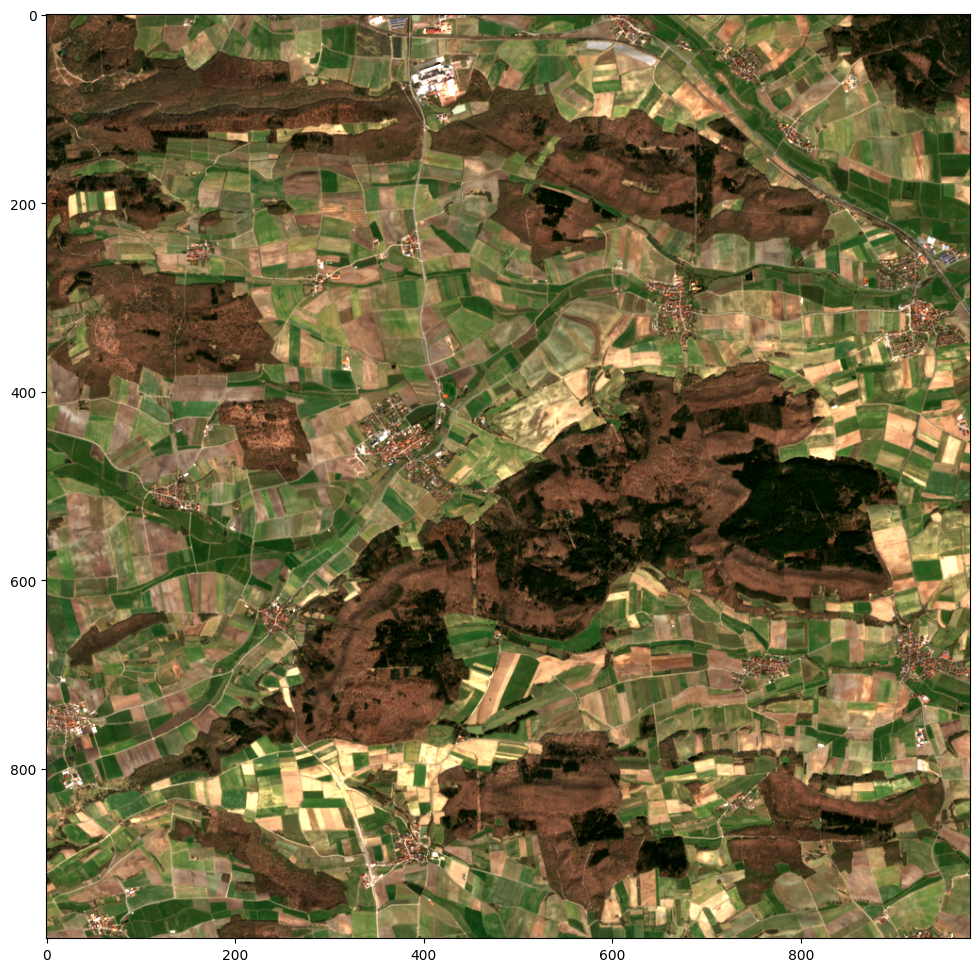

In [184]:
img_processed = img / 8
img_processed = img_processed.astype(int)
img_processed = robust_normalize(img_processed)
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_processed.transpose((2,0,1)), ax=ax);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


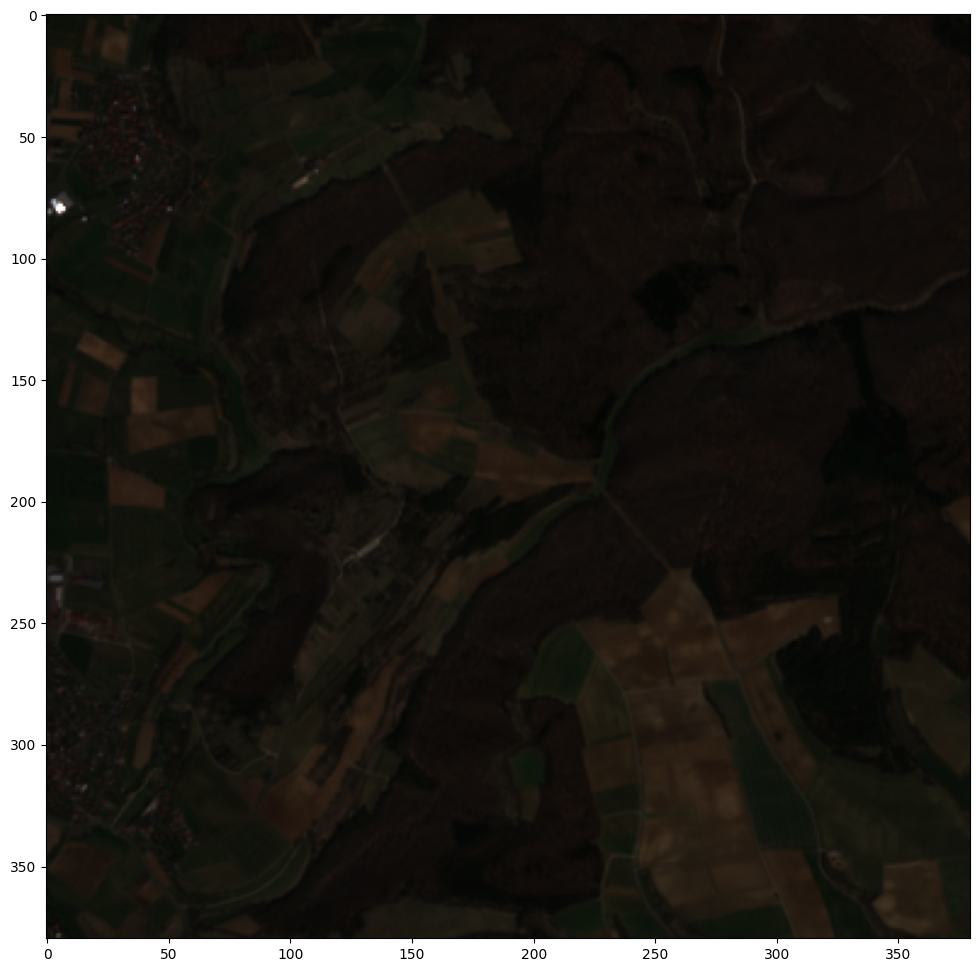

In [180]:
img_processed = img / 10000
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_processed.transpose((2,0,1)), ax=ax);

In [185]:
smp = {"B04": red, # red
        "B03": green, # green
        "B02": blue} # blue

In [186]:
red_corr, green_corr, blue_corr = evaluatePixel(smp)

In [188]:
red_corr.min()

-0.055

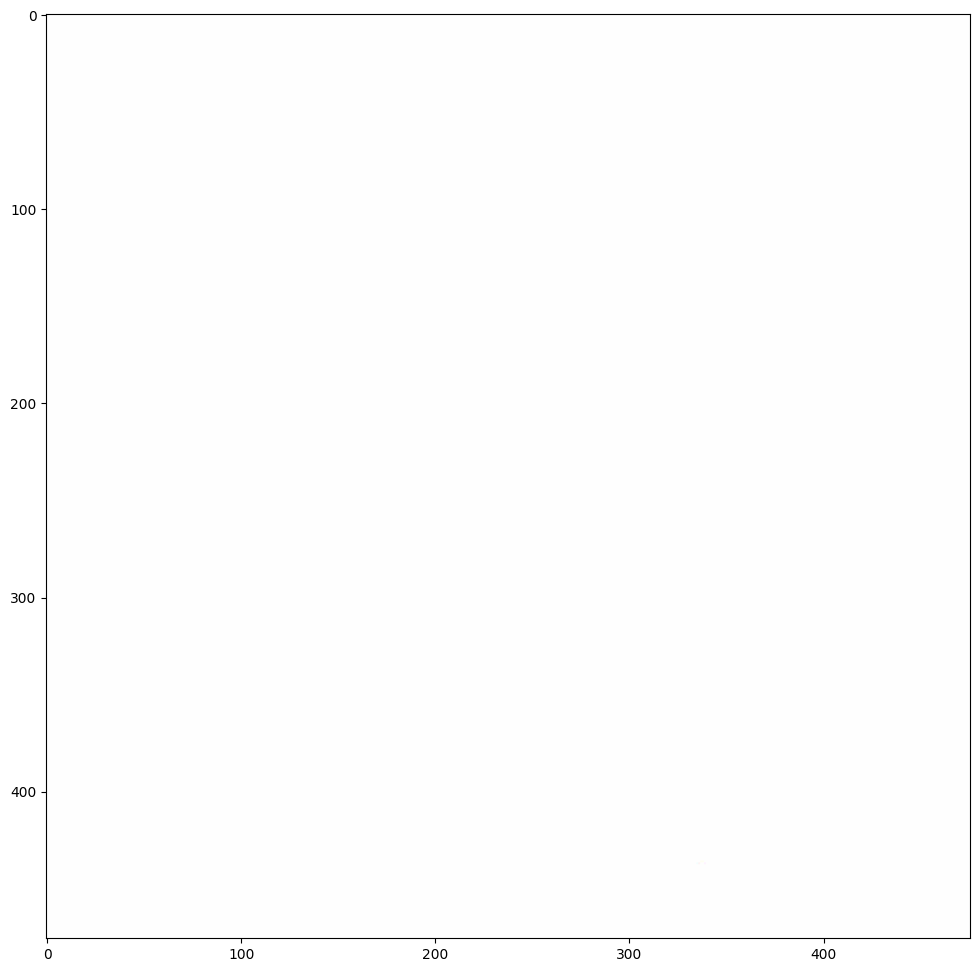

In [137]:
rgb_composite_corr = np.dstack((red_corr, green_corr, blue_corr))[1024:1500, 1024:1500, :]
fig, ax = plt.subplots(1, figsize=(12, 12))
show(rgb_composite_corr.transpose((2,0,1)), ax=ax);

In [133]:
rgb_composite_corr.shape

(10980, 10980, 3)